# Calculate Uniswap IV

## Import packages

In [1]:
from web3 import Web3
from math import sqrt

import json
import numpy as np
import pandas as pd
import pandas_gbq
import pydata_google_auth
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Grab Volume and Liquidity

In [2]:
class Uniswap_Pool:
    def __init__(
        self,
        token_0: str,
        token_1: str,
        fee: int, # in bps
        start_t: str,
        end_t: str,
        window: int, # in seconds
        inverse_price: bool=True,
    ) -> None:
        """
        Get Uniswap swap data and volume

        :token_0 Token 0
        :token_1 Token 1
        :fee fee rate in bps
        :start_t start time (inclusive) (i.e. '2021-05-06 00:06:12' or '2021-05-06')
        :end_t end time (exclusive)
        :inverse_price invert the price (if true: gets price of token_1 in terms of token_0)
        """
        self.token_0 = token_0
        self.token_1 = token_1
        self.fee_rate = fee / 10_000
        self.pool_address = Uniswap_Pool.get_pool_address(self.token_0, self.token_1, fee)
        self.dec_0 = Uniswap_Pool.get_token_dec(self.token_0)
        self.dec_1 = Uniswap_Pool.get_token_dec(self.token_1)
        self.tick_spacing = Uniswap_Pool.get_tick_spacing(fee)
        self.start_t = start_t
        self.end_t = end_t
        self.window = window
        self.BASE = 1.0001
        ''' If inverse_price, our numeraire is token_0
        Else, our numeraire is token_1
        Ex: For USDC/ETH pool:
        token 0 = USDC
        token 1 = ETH
        Inverse_price = True -> we calculate returns in terms of USDC
        Inverse_price = False -> we calculate returns in terms of ETH
        This will affect results! '''
        self.inverse_price = inverse_price
        self.load_pool_data()

    def load_pool_data(self):
        """Loads Univ3 pool swap data"""
        # Replace this function with your own GBQ data fetcher
        # See: https://github.com/panoptic-labs/research/blob/JP/_research-bites/DataTutorial/tutorial.ipynb
        print("Loading Data...")

        SCOPES = [
            'https://www.googleapis.com/auth/cloud-platform',
            'https://www.googleapis.com/auth/drive',
        ]

        credentials = pydata_google_auth.get_user_credentials(
            SCOPES,
            auth_local_webserver=True,
        )

        query = f"""
        SELECT DISTINCT *
        FROM `arcane-world-371019.First_sync.1`
        WHERE address = '{self.pool_address}'
            AND block_timestamp >= '{self.start_t}'
            AND block_timestamp < '{self.end_t}'
        ORDER BY block_number, transaction_index
        """
        self.data = pandas_gbq.read_gbq(query, project_id = "arcane-world-371019", credentials=credentials)
        self.transform_pool_data()

    def transform_pool_data(self):
        """Transform amounts to human-readable format"""
        self.data['amount0'] = self.data['amount0'].apply(Uniswap_Pool.get_twos_comp)
        self.data['amount1'] = self.data['amount1'].apply(Uniswap_Pool.get_twos_comp)

        self.data['amount0'] = self.data['amount0'] / (10 ** self.dec_0)
        self.data['amount1'] = self.data['amount1'] / (10 ** self.dec_1)
        self.data['amount_total'] = self.get_swapped_amounts()

        self.data['tick_lower'] = self.nearest_multiple_of_tick_spacing(self.data['tick'])
        self.data['tick_upper'] = self.data['tick_lower'] + self.tick_spacing

        # Convert liquidity from hex to integer
        self.data['liquidity'] = self.data['liquidity'].apply(lambda x: int(x, 16))

        # Calculate liquidity for token0 and token1
        self.data['liquidity_token0'] = self.data.apply(lambda row: self.get_token0_amount( \
            row['liquidity'], row['tick'], row['tick_upper']) / (10 ** self.dec_0), axis=1)
        self.data['liquidity_token1'] = self.data.apply(lambda row: self.get_token1_amount( \
            row['liquidity'], row['tick'], row['tick_lower']) / (10 ** self.dec_1), axis=1)
        self.data['liquidity_total'] = self.get_total_tick_liquidity()
        self.data['price'] = self.data['tick'].apply(self.convert_tick)

        # Note our GBQ query ordered by blocknumber, transaciton_index
        self.data.set_index('block_timestamp', inplace=True) # Assume block timestamps are accurate "enough" for our use-case
        self.data.index = pd.to_datetime(self.data.index)

        # Get trailing swap volume
        self.data['trailing_volume'] = self.get_trailing_volume(self.window, self.data['amount_total'], self.data.index)

        # Unpack sqrt price
        self.data['sqrtPrice'] = self.data['sqrtPrice'].apply(Uniswap_Pool.unpack_sqrtprice)

        # # Calculate sqrt price change
        # self.data = Uniswap_Pool.calc_sqrtprice_change(self.data)

        self.data['date'] = self.data.index.date
        # # Lag prices (Have to do for illiquid pools w/few txs per day)
        # self.data['price_lag'] = self.data['price'].shift()
        # self.data['tick_lag'] = self.data['tick'].shift()
        # self.data['sqrtPrice_lag'] = self.data['sqrtPrice'].shift()
        # self.data = self.data.iloc[1:]

        # Calculate Uniswap pool IV timeseries
        time_threshold = self.data.index[0] + pd.Timedelta(seconds=self.window)

        # Apply the calc_iv function and set NaN values for rows before the time threshold
        self.data['iv'] = self.data.apply(lambda row: np.nan if row.name < time_threshold \
            else self.calc_iv(self.fee_rate, row['trailing_volume'], row['liquidity_total'], self.window), axis=1)
        
    def convert_price(self, p: float) -> float:
        """Gets (inverse) price (convenient for pairs like USDC/ETH)
        Inverse price: price of token1 in terms of token0
        Regular price: price of token0 in terms of token1"""
        if self.inverse_price:
            return 10 ** (self.dec_1 - self.dec_0) / p
        else:
            return p / (10 ** (self.dec_1 - self.dec_0))

    def convert_tick(self, tick: int) -> float:
        """Converts tick to price"""
        return self.convert_price(self.BASE ** tick)

    def nearest_multiple_of_tick_spacing(self, tick: int) -> int:
        """Finds the nearest multiple of the tick spacing"""
        return (tick // self.tick_spacing) * self.tick_spacing
    
    def get_swapped_amounts(self) -> pd.Series:
        """Takes absolute value of all swapped amounts in terms of quote token
        Negative (token out) becomes positive
        Positive (token in) stays the same
        """
        if self.inverse_price:
            return abs(self.data['amount0']) # token0 is quote
        else:
            return abs(self.data['amount1']) # token1 is quote        
    
    def get_total_tick_liquidity(self) -> pd.Series:
        """Gets the current tick's total liquidity in terms of either token0 or token1"""

        if self.inverse_price:
            return self.data.apply(lambda row: self.get_total_token0_amount( \
                self.fee_rate, row['liquidity'], (row['tick_upper'] + row['tick_lower']) / 2), axis=1) \
                / (10 ** self.dec_0)
        else:
            return self.data.apply(lambda row: self.get_total_token1_amount( \
                self.fee_rate, row['liquidity'], (row['tick_upper'] + row['tick_lower']) / 2), axis=1) \
                / (10 ** self.dec_1)

    @staticmethod
    def tick_to_price(tick: int):
        """Calculate price from tick"""
        return 1.0001 ** tick

    @staticmethod
    def get_trailing_volume(window: int, amounts: pd.Series, ts: pd.Series) -> pd.Series:
        """Adds up past swap volume
        :window the trailing window (in seconds) to accumulate
        :swap amounts, must be of the same token type (either token0 or token1)
        :ts timestamps corresponding with swap amounts
        """        
        trailing_volumes = []
        window_timedelta = pd.Timedelta(seconds=window)
        
        for i in range(len(ts)):
            current_time = ts[i]
            start_index = ts.searchsorted(current_time - window_timedelta, side='left')
            trailing_volume = amounts[start_index:i+1].sum()
            trailing_volumes.append(trailing_volume)
        return pd.Series(trailing_volumes, index=amounts.index)

    @staticmethod
    def calc_iv(fee_rate: float, volume: float, tickLiq: float, window: int):
        """Calculates the IV of the pool based on Guillaume's formula https://panoptic.xyz/research/new-formulation-implied-volatility#step-5-derive-the-implied-volatility-iv
        
        :fee_rate Uniswap pool fee tier
        :volume the total volume of swapped amounts in the past window
        :tickLiq the current tick's total liquidity
        :window the number of seconds we are using to lookback at volume"""
        num_secs_in_year = 60*60*24*365
        annualization_factor = num_secs_in_year / window
        return 2 * fee_rate * np.sqrt(volume / tickLiq) * np.sqrt(annualization_factor)

    @staticmethod
    def get_token0_amount(liquidity: int, tick_current: int, tick_upper: int):
        """Gets the token0 contribution toward current tick's liquidity
       
        :liquidity the raw liquidity value from Uniswap's onchain pool data
        :tick_current the current tick of the Uniswap pool
        :tick_upper the upper tick of the liquidity chunk (corresponds to the lower price of the LP position)"""
        return (liquidity) * (1 / sqrt(Uniswap_Pool.tick_to_price(tick_current)) - 1 / sqrt(Uniswap_Pool.tick_to_price(tick_upper)))

    @staticmethod
    def get_token1_amount(liquidity: int, tick_current: int, tick_lower: int):
        """Gets the token1 contribution toward current tick's liquidity
        
        :liquidity the raw liquidity value from Uniswap's onchain pool data
        :tick_current the current tick of the Uniswap pool
        :tick_lower the lower tick of the liquidity chunk (corresponds to the upper price of the LP position)"""
        return liquidity * (sqrt(Uniswap_Pool.tick_to_price(tick_current)) - sqrt(Uniswap_Pool.tick_to_price(tick_lower)))
    
    @staticmethod
    def get_total_token0_amount(fee_rate: float, liquidity: int, tick_mid: int):
        """Gets the current tick's total liquidity, but converted to token0
        
        :fee_rate the pool's fee tier
        :liquidity the raw liquidity value from Uniswap's onchain pool data
        :tick_mid the strike price of the liquidity chunk"""
        return (liquidity * fee_rate) / np.sqrt(Uniswap_Pool.tick_to_price(tick_mid))

    @staticmethod
    def get_total_token1_amount(fee_rate: float, liquidity: int, tick_mid: int):
        """Gets the current tick's total liquidity, but converted to token1
        
        :fee_rate the pool's fee tier
        :liquidity the raw liquidity value from Uniswap's onchain pool data
        :tick_mid the strike price of the liquidity chunk"""
        return liquidity * fee_rate * np.sqrt(Uniswap_Pool.tick_to_price(tick_mid))    

    @staticmethod
    def get_twos_comp(hex_str: str, bits: int=256) -> float:
        """Calculate two's complement"""
        num = int(hex_str, 16)
        if (num & (1 << (bits - 1))) != 0: # Check if first bit is set
            num = num - (1 << bits)        # Get two's complement
        return num
    
    @staticmethod
    def unpack_sqrtprice(sqrt_p: str) -> float:
        """Unpacks sqrt price from raw UNI V3 pool data"""
        return int(sqrt_p, 16) / (2 ** 96)
    
    @staticmethod
    def calc_sqrtprice_change(df: pd.DataFrame) -> pd.DataFrame:
        """Stores previous sqrt price and calculates delta"""
        df['prev_sqrtPrice'] = df['sqrtPrice'].shift()
        df['change_sqrtPrice'] = df['sqrtPrice'] - df['prev_sqrtPrice']
        return df
    
    @staticmethod
    def get_pool_address(token_0: str, token_1: str, fee: int) -> str:
        """Gets Univ3 Pool Address"""
        # Source: https://info.uniswap.org/#/pools
        # Feel free to add additional pools
        # (make sure token0 and token1 are specified in the same order as on Uniswap!)
        # Ex: '[token0]/[token1] [fee]bps': '[pool_address]',
        pools = {
            '1INCH/ETH 100bps': '0xe931b03260b2854e77e8da8378a1bc017b13cb97',
            'AAVE/ETH 30bps': '0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb',
            'APE/ETH 30bps': '0xac4b3dacb91461209ae9d41ec517c2b9cb1b7daf',
            'BIT/ETH 30bps': '0x5c128d25a21f681e678cb050e551a895c9309945',
            'BUSD/USDC 5bps': '0x00cef0386ed94d738c8f8a74e8bfd0376926d24c',
            'cbETH/ETH 5bps': '0x840deeef2f115cf50da625f7368c24af6fe74410',
            'DAI/ETH 5bps': '0x60594a405d53811d3bc4766596efd80fd545a270',
            'DAI/ETH 30bps': '0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8',
            'DAI/USDC 1bps': '0x5777d92f208679db4b9778590fa3cab3ac9e2168',
            'DAI/USDC 5bps': '0x6c6bc977e13df9b0de53b251522280bb72383700',
            'DAI/FRAX 5bps': '0x97e7d56a0408570ba1a7852de36350f7713906ec',
            'ETH/BTT 30bps': '0x64a078926ad9f9e88016c199017aea196e3899e1',
            'ETH/ENS 30bps': '0x92560c178ce069cc014138ed3c2f5221ba71f58a',
            'ETH/LOOKS 30bps': '0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011',
            'ETH/sETH2 30bps': '0x7379e81228514a1d2a6cf7559203998e20598346',
            'ETH/USDT 5bps': '0x11b815efb8f581194ae79006d24e0d814b7697f6',
            'ETH/USDT 30bps': '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
            'FRAX/USDC 5bps': '0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52',
            'GNO/ETH 30bps': '0xf56d08221b5942c428acc5de8f78489a97fc5599',
            'HEX/ETH 30bps': '0x9e0905249ceefffb9605e034b534544684a58be6',
            'HEX/USDC 30bps': '0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5',
            'LDO/ETH 30bps': '0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74',
            'LINK/ETH 30bps': '0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8',
            'MATIC/ETH 30bps': '0x290a6a7460b308ee3f19023d2d00de604bcf5b42',
            'MKR/ETH 30bps': '0xe8c6c9227491c0a8156a0106a0204d881bb7e531',
            'SHIB/ETH 30bps': '0x2f62f2b4c5fcd7570a709dec05d68ea19c82a9ec',
            'UNI/ETH 30bps': '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801',
            'USDC/ETH 1bps': '0xe0554a476a092703abdb3ef35c80e0d76d32939f',
            'USDC/ETH 5bps': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
            'USDC/ETH 30bps': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
            'USDC/ETH 100bps': '0x7bea39867e4169dbe237d55c8242a8f2fcdcc387',
            'USDC/USDT 1bps': '0x3416cf6c708da44db2624d63ea0aaef7113527c6',
            'USDC/USDT 5bps': '0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf',
            'USDC/USDM 5bps': '0x8ee3cc8e29e72e03c4ab430d7b7e08549f0c71cc',
            'WBTC/ETH 5bps': '0x4585fe77225b41b697c938b018e2ac67ac5a20c0',    
            'WBTC/ETH 30bps': '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed',
            'WBTC/USDC 30bps': '0x99ac8ca7087fa4a2a1fb6357269965a2014abc35',
            'WOOF/ETH 100bps': '0x666ed8c2151f00e7e58b4d941f65a9df68d2245b',
        }

        pool_name = f"{token_0}/{token_1} {str(fee)}bps"
        try:
            pool_address = pools[pool_name]
        except KeyError:
            return None
        return pool_address

    @staticmethod
    def get_token_dec(token: str) -> int:
        """Gets number of decimals corresponding to token"""
        # Source: https://apiv5.paraswap.io/tokens/?network=1 & https://etherscan.io/tokens
        decimals = {
            '1INCH': 18,
            'AAVE': 18,
            'APE': 18,
            'BIT': 18,
            'BTT': 18,
            'BUSD': 18,
            'cbETH': 18,
            'DAI': 18,
            'ENS': 18,
            'ETH': 18,
            'FRAX': 18,
            'GNO': 18,
            'HEX': 8,
            'LDO': 18,
            'LINK': 18,
            'LOOKS': 18,
            'MATIC': 18,
            'MKR': 18,
            'sETH2': 18,
            'SHIB': 18,
            'UNI': 18,
            'USDC': 6,
            'USDM': 18,
            'USDT': 6,
            'WBTC': 8,
            'WOOF': 18,
        }
        try:
            dec = decimals[token]
        except KeyError:
            return None
        return dec

    @staticmethod
    def get_tick_spacing(fee: int) -> int:
        """
        Gets Univ3 tick spacing corresponding to fee-tier

        :fee fee-tier in bps
        """
        spacing = {
            1: 1,
            5: 10,
            30: 60,
            100: 200
        }
        try:
            space = spacing[fee]
        except KeyError:
            return None
        return spacing[fee]

In [3]:
volume = Uniswap_Pool(
            token_0 = 'WBTC',
            token_1 = 'USDC',
            fee = 30,
            start_t = '2021-05-01',
            end_t = '2025-07-01',
            window = 60 * 60 * 24,
            inverse_price = False,
)

(volume.data.iv * 100).describe()

Loading Data...
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


count    291712.000000
mean         73.586463
std          57.181595
min           0.551506
25%          42.186617
50%          58.925708
75%          83.334899
max         827.491081
Name: iv, dtype: float64

In [4]:
# Extract and clean the relevant time series
df = volume.data.copy()
df = df[['price', 'iv']].dropna()

# Resample to daily frequency using the last available value each day
daily = df.resample('1D').last()

# Compute daily simple returns for spot price and IV
daily['price_return'] = daily['price'].pct_change()
daily['iv_change'] = daily['iv'].pct_change()

# Drop NaNs after computing changes
daily.dropna(inplace=True)

<>:12: SyntaxWarning: invalid escape sequence '\P'
<>:12: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ndbur\AppData\Local\Temp\ipykernel_67588\1136663587.py:12: SyntaxWarning: invalid escape sequence '\P'
  plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')


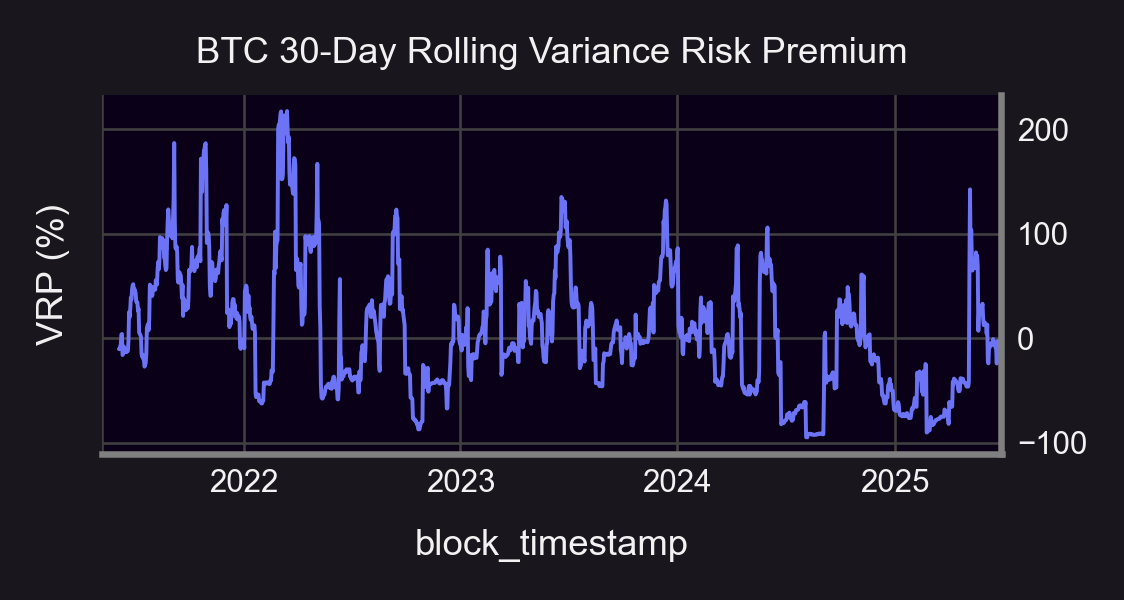

In [5]:
# Calculate 30-day realized volatility using the given formula
daily['realized_vol'] = np.sqrt((365/30) * (daily['price_return'] ** 2).rolling(window=30).sum())
# Convert to realized variance (in %^2 terms)
realized_var = (daily['realized_vol'] ** 2) 
# Recompute implied variance in %^2
implied_var = (daily['iv'] ** 2).rolling(window=30).std()

# Compute VRP
daily['vrp'] = ((realized_var / implied_var) - 1) * 100

# Plot VRP
plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')
daily['vrp'].plot(title='BTC 30-Day Rolling Variance Risk Premium')
plt.ylabel('VRP (%)')
plt.savefig("BTC VRP.png")

In [6]:
daily['rv_change'] = daily['realized_vol'].pct_change()

In [7]:
rolling_correlation = daily['rv_change'].rolling(window=30).corr(daily['price_return'])

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ndbur\AppData\Local\Temp\ipykernel_67588\1083227300.py:2: SyntaxWarning: invalid escape sequence '\P'
  plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')


BTC Spot-RV Correlation: 0.0222


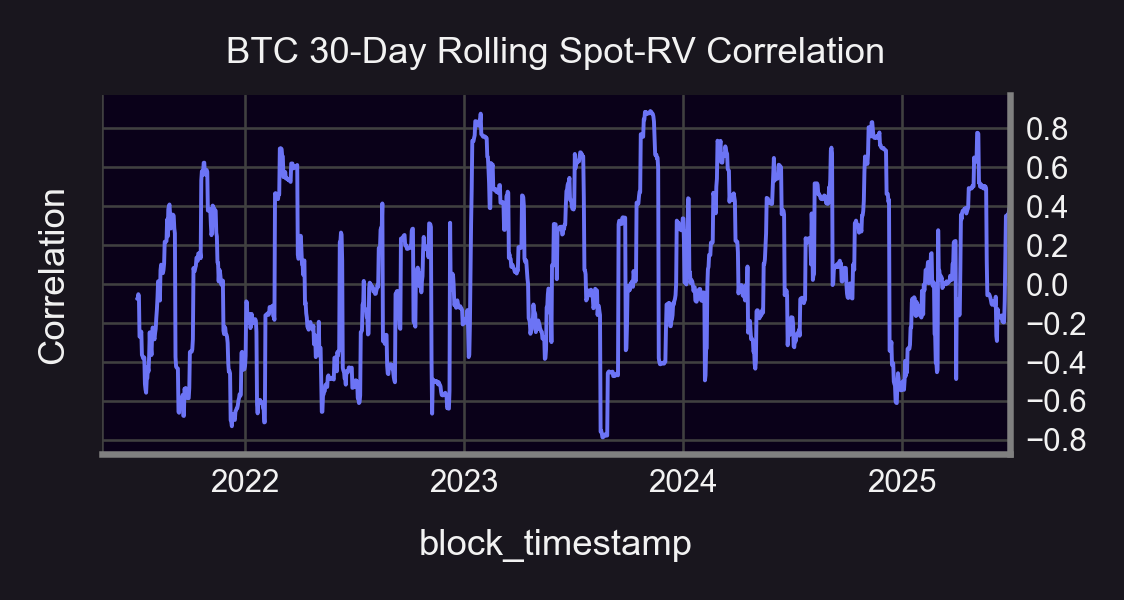

In [8]:
# Plot the rolling correlation
plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')

correlation = daily['price_return'].corr(daily['rv_change'])
print(f"BTC Spot-RV Correlation: {correlation:.4f}")
rolling_correlation.plot()
plt.title('BTC 30-Day Rolling Spot-RV Correlation')
plt.ylabel('Correlation')
plt.yticks(np.arange(-0.8, 1, 0.2))
plt.savefig("BTC Spot-RV Correlation.png")

In [9]:
# Compute rolling 30-day upside and downside realized volatilities
daily['rv_up'] = np.sqrt((365/30) * (daily['price_return'].where(daily['price_return'] > 0, 0) ** 2).rolling(window=30).sum())
daily['rv_up_change'] = daily['rv_up'].pct_change()
daily['rv_down'] = np.sqrt((365/30) * (daily['price_return'].where(daily['price_return'] <= 0, 0) ** 2).rolling(window=30).sum())
daily['rv_down_change'] = daily['rv_down'].pct_change()

<>:46: SyntaxWarning: invalid escape sequence '\P'
<>:46: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ndbur\AppData\Local\Temp\ipykernel_67588\3632035230.py:46: SyntaxWarning: invalid escape sequence '\P'
  plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')


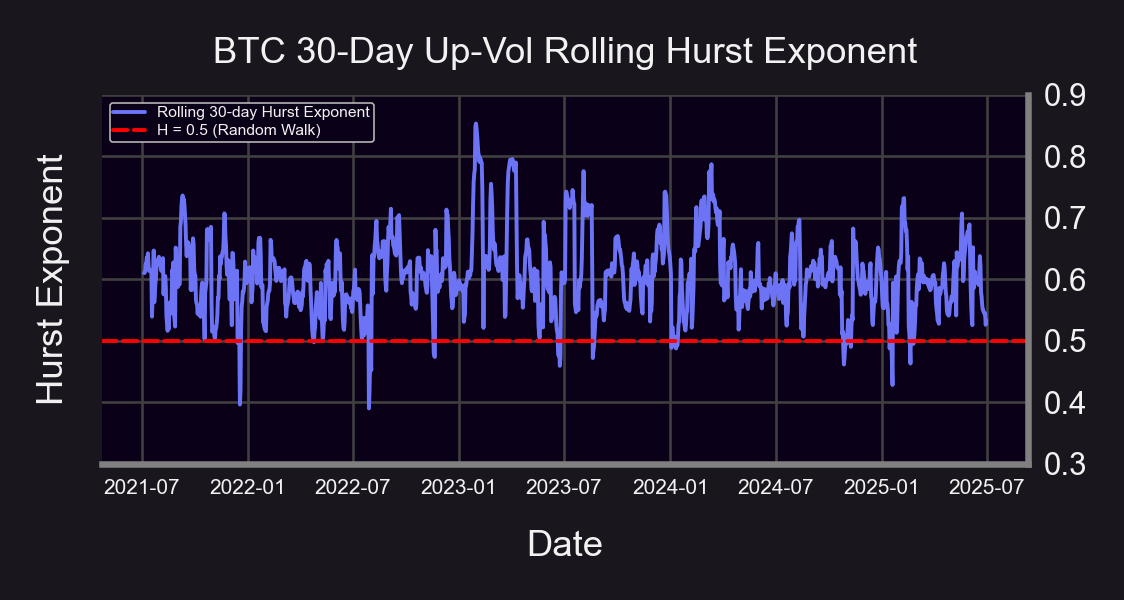

In [10]:
def hurst_exponent(ts, max_lag=20):
    """
    Estimate the Hurst exponent H of a time series using the rescaled range (R/S) method.

    Parameters:
    - ts: 1D numpy array or list, the time series.
    - max_lag: Maximum number of lags to test (default: 100)

    Returns:
    - Hurst exponent H (float)
    """
    ts = np.array(ts)
    N = len(ts)
    lags = range(2, max_lag)

    tau = []
    for lag in lags:
        # Split series into segments
        num_segments = N // lag
        reshaped = ts[:num_segments * lag].reshape((num_segments, lag))
        
        rs = []
        for segment in reshaped:
            mean_adj = segment - np.mean(segment)
            cum_dev = np.cumsum(mean_adj)
            R = np.max(cum_dev) - np.min(cum_dev)
            S = np.std(segment)
            if S != 0:
                rs.append(R / S)

        if len(rs) > 0:
            tau.append(np.mean(rs))

    # Linear fit in log-log scale
    log_lags = np.log(lags)
    log_tau = np.log(tau)
    H, _ = np.polyfit(log_lags, log_tau, 1)

    return H


# --- Rolling Hurst Exponent ---
daily['H'] = daily['rv_up_change'].rolling(30).apply(lambda x: hurst_exponent(x, 20), raw=False)

# --- Plot ---
plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')
plt.plot(daily.index, daily['H'], label='Rolling 30-day Hurst Exponent')
plt.axhline(0.5, color='red', linestyle='--', label='H = 0.5 (Random Walk)')
plt.title("BTC 30-Day Up-Vol Rolling Hurst Exponent")
plt.xlabel("Date")
plt.ylabel("Hurst Exponent")
plt.xticks(fontsize=4)
plt.yticks(np.arange(0.3, 0.9, 0.1))
plt.legend(loc='upper left', fontsize=3)
plt.savefig("BTC Up-Vol Rolling Hurst.png")

<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ndbur\AppData\Local\Temp\ipykernel_67588\1133618162.py:4: SyntaxWarning: invalid escape sequence '\P'
  plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')


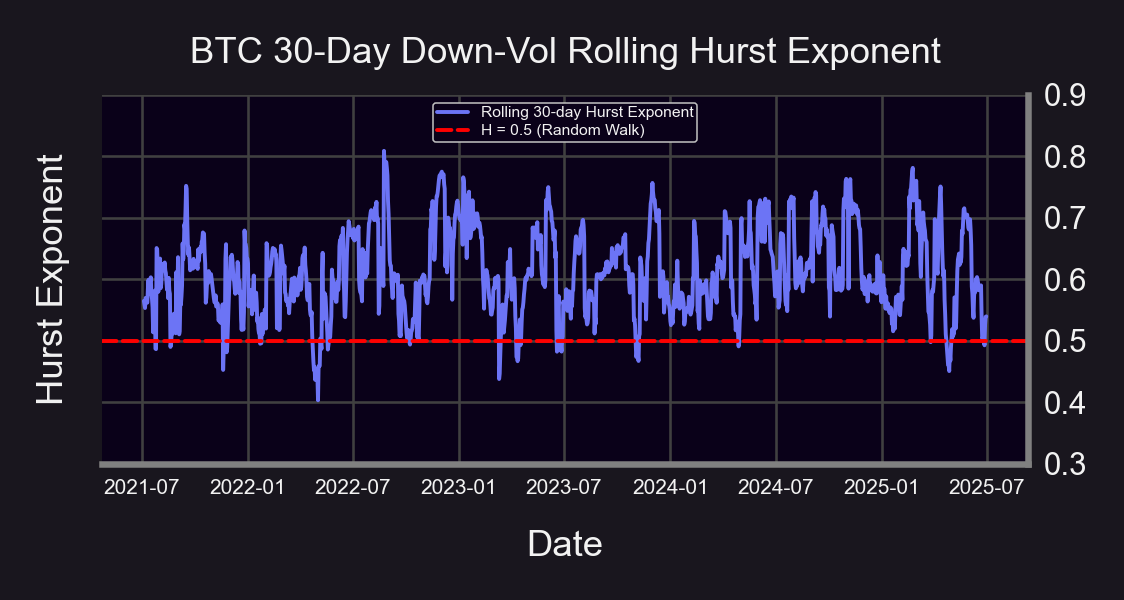

In [11]:
daily['H'] = daily['rv_down_change'].rolling(30).apply(lambda x: hurst_exponent(x, 20), raw=False)

# --- Plot ---
plt.style.use('E:\Panoptic (ABI & MPL Files)\panoptic-dark-16_9.mplstyle')
plt.plot(daily.index, daily['H'], label='Rolling 30-day Hurst Exponent')
plt.axhline(0.5, color='red', linestyle='--', label='H = 0.5 (Random Walk)')
plt.title("BTC 30-Day Down-Vol Rolling Hurst Exponent")
plt.xlabel("Date")
plt.ylabel("Hurst Exponent")
plt.xticks(fontsize=4)
plt.yticks(np.arange(0.3, 0.9, 0.1))
plt.legend(loc='upper center', fontsize=3)
plt.savefig("BTC Down-Vol Rolling Hurst.png")